# Task 1

$$
x_t = x_{t-1} + u_{t-1} + \epsilon_{t-1}
$$

$$
z_t = x_t + \eta_t
$$

$$
\epsilon_t \sim N(0, \sigma_t)
$$


$$
\eta_t \sim N(0, p_t)
$$

In [ ]:
import pickle
import pandas as pd

data = pd.read_pickle(r'nonstationary_LDS.pickle')
data.keys()

dict_keys(['u', 'sigma', 'rho', 'z'])

In [ ]:
u = data["u"]
z = data["z"]
rho = data["rho"]
sigma = data["sigma"]

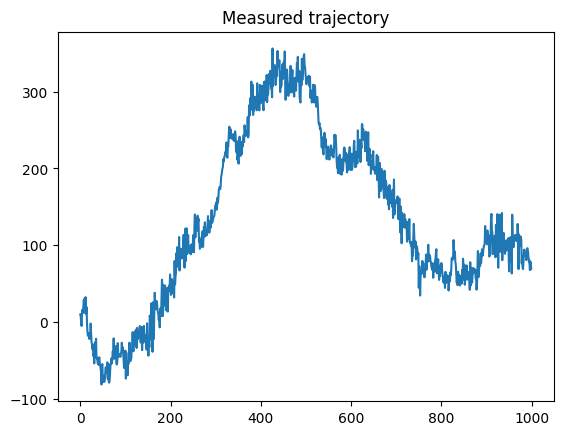

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

T = len(z)
plt.plot(np.arange(T), z)
plt.title('Measured trajectory');

1. Filtering

Using Kalman filter we get:

$$
\hat x_t = K_t z_t + (1 - K_t) (\hat x_{t-1} + u_{t-1})
$$

$$
K_t = \frac{err_{t-1}^2 + \sigma_{t-1}^2}{err_{t-1}^2 + \sigma_{t-1}^2 + p_t^2}
$$

$$
err_t^2 = p_t^2 K_t
$$

In [ ]:
err2 = np.zeros(T)
x_est = np.zeros(T)
K = np.zeros(T)

err2[0] = rho[0]**2
K[0] = 1
x_est[0] = z[0]

In [ ]:
for i in range(1, T):
  K[i] = (err2[i - 1] + sigma[i-1]**2) / (err2[i - 1] + sigma[i-1]**2 + rho[i]**2)
  err2[i] = K[i] * rho[i]**2
  x_est[i] = K[i]*z[i] + (1 - K[i]) * (x_est[i-1] + u[i - 1])

In [ ]:
def print_res(start = 0, end=T):
  plt.plot(np.arange(T)[start:end], z[start:end])
  plt.fill_between(np.arange(T)[start:end], (x_est+2*err2**0.5)[start:end], (x_est-2*err2**0.5)[start:end], alpha=.5)
  plt.plot(np.arange(T)[start:end], x_est[start:end], color="red")

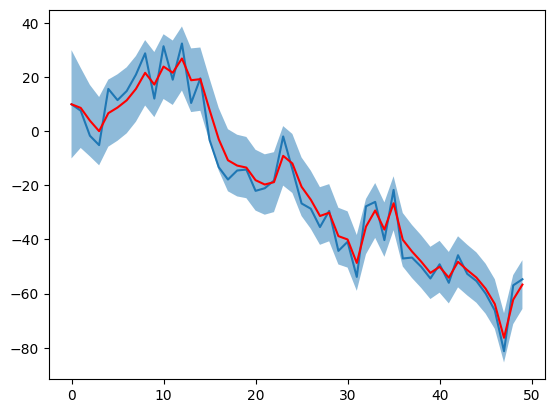

In [ ]:
print_res(0, 50)

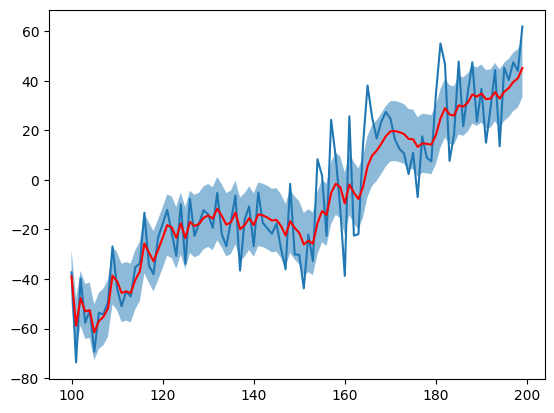

In [ ]:
print_res(100, 200)

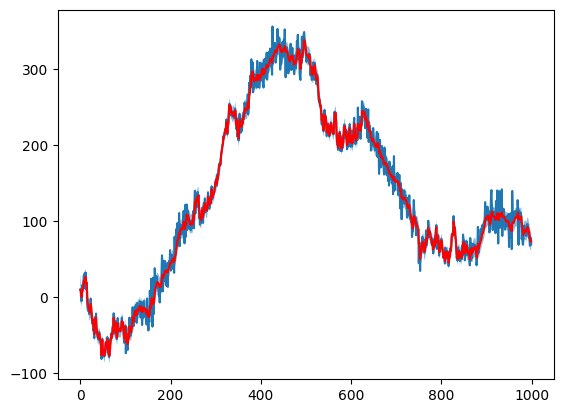

In [ ]:
print_res()

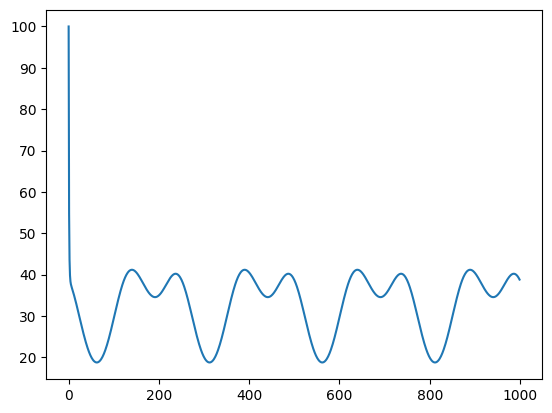

In [ ]:
plt.plot(err2)

2. Smoothing

$$
P(x_0,x_1,...,x_T)|\textrm{observations}(t=T))\propto P(\eta_0, ...,\eta_T, \epsilon_0,...,\epsilon_{T-1}|x_0, x_1,...x_T)
$$
$$
= Const * \exp(-\sum_{t=0}^T \frac{(x_t - z_t)^2}{2p_t^2} - \sum_{t=0}^{T-1} \frac{(x_{t+1} - x_t - u_t)^2}{2\sigma_t^2})
$$

$$
= Const *  \exp(-\sum_{t=0}^T \frac{x_t^2 -2x_t z_t + z_t^2}{2p_t^2} - \sum_{t=0}^{T-1} \frac{x_{t+1}^2 - 2x_{t+1}x_t + x_t^2 - 2x_{t+1}u_t + 2x_tu_t + u_t^2}{2\sigma_t^2})
$$

This can be expressed as:
$$
Const * \exp(-\frac{1}{2}x^TAx + Bx + c)
$$

, with

$$
A = \left(
\begin{array}{cccc}
 \frac{1}{p_0 ^2}+\frac{1}{\sigma_0 ^2} & -\frac{1}{\sigma_0 ^2} & 0 & 0 & ... \\
 -\frac{1}{\sigma_0 ^2} & \frac{1}{p_1 ^2}+\frac{1}{\sigma_1 ^2} + \frac{1}{\sigma_0^2} & -\frac{1}{\sigma_1 ^2} & 0 & ...\\
 0 & -\frac{1}{\sigma_1 ^2} & \frac{1}{p_2 ^2}+\frac{1}{\sigma_2 ^2} + \frac{1}{\sigma_1 ^2} & -\frac{1}{\sigma_2 ^2} & ...\\
 ...
 \\
 0 & 0 &  ... &-\frac{1}{\sigma_{T-1} ^2} & \frac{1}{p_T ^2}+\frac{1}{\sigma_{T-1} ^2} \\
\end{array}
\right)
$$

$$
B = \left(
\begin{array}{cccc}
\frac{z_0}{p_0^2} -\frac{u_0}{\sigma_0^2} , \frac{z_1}{p_1^2} -\frac{u_1}{\sigma_1^2} + \frac{u_0}{\sigma_0^2} , \frac{z_2}{p_2^2} -\frac{u_2}{\sigma_2^2} + \frac{u_1}{\sigma_1^2} , ... , \frac{z_T}{p_T^2} + \frac{u_{T-1}}{\sigma_{T-1}^2}
\end{array}
\right)
$$

Maximization on this expression means minimization of: $\exp(\frac{1}{2}x^TAx - Bx - c)$

So, need to solve:
$$
Ax^{*} = B
$$

In [ ]:
np.diag([-1/sigma[t]**2 for t in range(T-1)], k=-1).shape

(1000, 1000)

In [ ]:
diag_data = [1/(rho[0]**2) + 1/(sigma[0]**2)] + \
            [1/(rho[t]**2) + 1/(sigma[t]**2) + 1/(sigma[t-1]**2)  for t in range(1, T - 1)] + \
            [1/(rho[T-1]**2) + 1/(sigma[T-2]**2)]
A_diag = np.diag(diag_data)

A = A_diag + np.diag([-1/sigma[t]**2 for t in range(T-1)], k=1) + np.diag([-1/sigma[t]**2 for t in range(T-1)], k=-1)

B = [z[0]/rho[0]**2 - u[0]/sigma[0]**2] + \
    [z[t]/rho[t]**2 - u[t]/sigma[t]**2 + u[t-1]/sigma[t-1]**2 for t in range(1, T-1)] + \
    [z[T-1]/rho[T-1]**2 + u[T-2]/sigma[T-2]**2]

In [ ]:
x_star = np.linalg.solve(A, B)

In [ ]:
def print_res(start = 0, end=T):
  plt.plot(np.arange(T)[start:end], z[start:end])
  plt.plot(np.arange(T)[start:end], x_est[start:end], color="red")
  plt.plot(np.arange(T)[start:end], x_star[start:end], color="green")
  plt.legend(["$x_{measured}$", "$x_{filtered}$", "$x_{smoothed}$"])

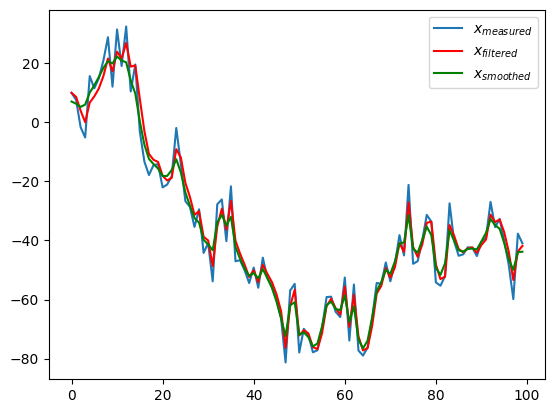

In [ ]:
print_res(0, 100)

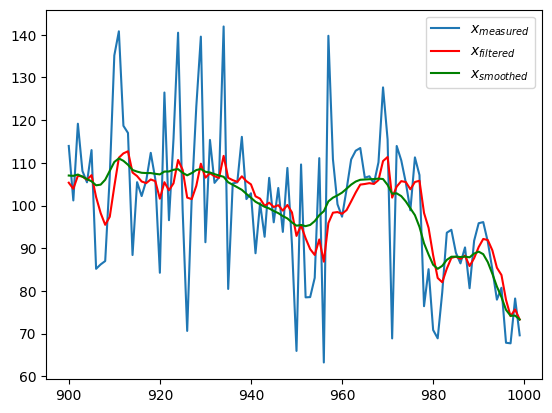

In [ ]:
print_res(900, 1000)

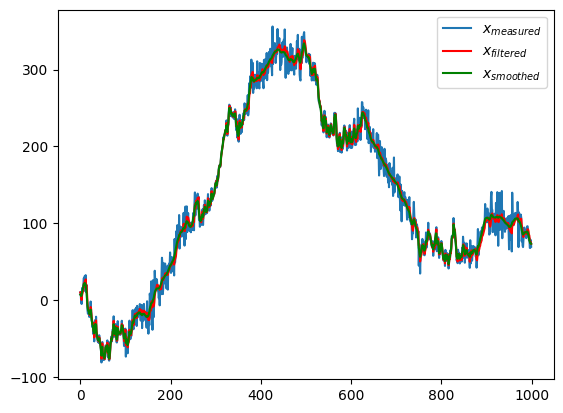

In [ ]:
print_res()

3. Prdiction for location at time T+1: $x_{T+1} = x_T + u_T$



In [ ]:
x_pred = x_est[T - 1] + u[T-1]
print(x_pred)

73.31135020954709


# Task 2

In [11]:
import pickle
import pandas as pd
import numpy as np

data = pd.read_pickle(r'2DMotion.pickle')
data.keys()

dict_keys(['sigma', 'rho', 'y', 'Delta'])

In [12]:
sigma = data["sigma"]
rho = data["rho"]
y = data["y"]
Delta = data["Delta"]

In [16]:
T = len(y)
T

100

In [13]:
A = np.array([[1, 0, Delta, 0], [0, 1, 0, Delta], [0, 0, 1, 0], [0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

In [14]:
Q = np.diag([ sigma, sigma, sigma, sigma ])
R = np.diag([ rho, rho ])

In [51]:
z = np.array([[0, 0, 0, 0]]*T)
err = np.array([[[0, 0, 0, 0]] * 4 ]*T)

# prior guess
z[0] = [y[0][0], y[0][1], 0, 0]
err[0] = np.diag([ 1e6 ] * 4)

In [52]:
def get_next_estimate(prev_mu, prev_err, y_true):
  mu = A @ prev_mu
  err = A @ prev_err @ A.T + Q

  K = np.linalg.inv((np.linalg.inv(err) + C.T @ np.linalg.inv(R) @ C)) @ C.T @ np.linalg.inv(R)

  new_mu = mu
  if y_true is not None:
      y_est = C @ mu
      r = y_true - y_est
      new_mu = mu + K @ r

  new_err = (np.identity(4) - K @ C) @ err

  return new_mu, new_err

for i in range(1, T):
  z[i], err[i] = get_next_estimate(z[i-1], err[i-1], y[i])

In [53]:
z = np.array(z)

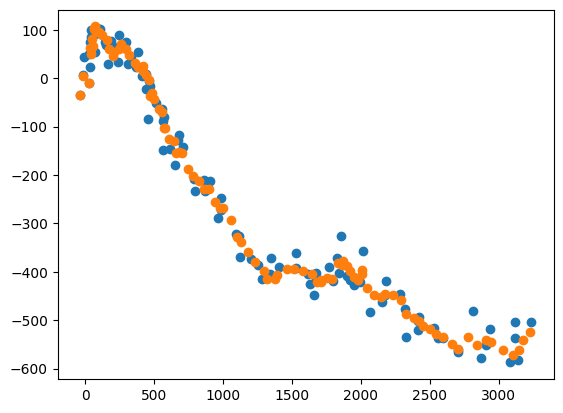

In [54]:
import matplotlib.pyplot as plt

plt.scatter(y[:,0], y[:,1])
plt.scatter(z[:,0], z[:,1])

In [58]:
# prediction
next_prediction, _ = get_next_estimate(z[T - 1], err[T - 1], None)
print(f'Next position: {next_prediction[:2]}')

Next position: [3277 -519]


# Task 3

$$
x_t = x_{t-1} + 1 + \epsilon_{t-1} (u = 1)
$$

$$
z_t = x_t + \eta_t
$$

$$
\epsilon_t \sim N(0, \sigma)
$$


$$
\eta_t \sim N(0, \rho)
$$

Compute $lnP(\sigma, \rho)$ and find optimal values of $\sigma$ and $\rho$.

$$
P(\sigma, \rho) \propto \int{P(x, z, \sigma, \rho)}dx
$$

$$
P(x, z, \sigma, \rho) = \prod_{t=0}^T \frac{1}{\sqrt{2\pi}\rho} \exp(\frac{(x_t - z_t)^2}{2\rho^2}) ̇ \prod_{t=0}^{T-1}\frac{1}{\sqrt{2\pi}\sigma} \exp(\frac{(x_{t+1} - x_{t} - 1)^2}{2\sigma^2})
$$

$$
\int{P(x, z, \sigma, \rho)}dx = (\frac{1}{\sqrt{2\pi}\rho})^{T+1} (\frac{1}{\sqrt{2\pi} \sigma})^{T}  \int {\exp(-\sum_{t=0}^T \frac{x_t^2 -2x_t z_t + z_t^2}{2\rho^2} - \sum_{t=0}^{T-1} \frac{x_{t+1}^2 - 2x_{t+1}x_t + x_t^2 - 2x_{t+1} + 2x_t + 1}{2\sigma_t^2})} dx
$$


Degree of exponenta under integral can be expressed as:

$$
-\frac{1}{2}(\sum_{t=0}^T\frac{x_t^2}{\rho^2} + \sum_{t=1}^T\frac{x_t^2}{\sigma^2} + \sum_{t=0}^{T-1}\frac{x_t^2}{\sigma^2} - \sum_{t=0}^{T-1}\frac{2x_{t+1}x_t}{\sigma^2}) + (\sum_{t=0}^T\frac{x_t z_t}{\rho^2} + \sum_{t=1}^T\frac{x_t}{\sigma^2} - \sum_{t=0}^{T-1}\frac{x_t}{\sigma^2}) -\frac{1}{2}(\sum_{t=0}^{T}\frac{z_t^2}{\rho^2} + \frac{T}{\sigma^2})
$$

, which can be rewritten as:

$$
-\frac{1}{2} x^TAx + b^Tx + c
$$

, with

$$
A = \left(
\begin{array}{cccc}
 \frac{1}{p ^2}+\frac{1}{\sigma ^2} & -\frac{1}{\sigma ^2} & 0 & 0 & ... \\
 -\frac{1}{\sigma ^2} & \frac{1}{p ^2}+\frac{2}{\sigma^2} & -\frac{1}{\sigma^2} & 0 & ...\\
 0 & -\frac{1}{\sigma^2} & \frac{1}{p^2}+\frac{2}{\sigma^2} & -\frac{1}{\sigma^2} & ...\\
 ...
 \\
 0 & 0 &  ... &-\frac{1}{\sigma^2} & \frac{1}{p^2}+\frac{1}{\sigma^2} \\
\end{array}
\right)
$$

$$
b^T = \left(
\begin{array}{cccc}
\frac{z_0}{p^2} -\frac{1}{\sigma^2} , \frac{z_1}{p^2} , \frac{z_2}{p^2}, ... , \frac{z_T}{p^2} + \frac{1}{\sigma^2}
\end{array}
\right)
$$

$$
c = -\sum_{t=0}^{T}\frac{z_t^2}{2\rho^2} - \frac{T}{2\sigma^2}
$$

$$
\int{P(x, z, \sigma, \rho)}dx = (\frac{1}{\sqrt{2\pi}\rho})^{T+1} (\frac{1}{\sqrt{2\pi} \sigma})^{T} \exp^C \int \exp(-\frac{1}{2} x^TAx + b^Tx)dx
$$

$$
= (\frac{1}{\sqrt{2\pi}\rho})^{T+1} (\frac{1}{\sqrt{2\pi} \sigma})^{T} \exp^C \sqrt{\frac{(2\pi)^T}{det(A)}} \exp(\frac{1}{2}b^TA^{-1}b)
$$

Lets find ln of this integral:

$$
lnP(\sigma, \rho) \propto -(T + 1)\ln(\sqrt(2\pi)\rho) - T\ln(\sqrt(2\pi)\sigma) + c + \frac{T}{2}\ln(2\pi) - \frac{1}{2}\ln \det(A) + \frac{1}{2}b^TA^{-1}b
$$

In [1]:
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from scipy import optimize

data = pd.read_pickle(r'1D_LL.pickle')
data.keys()

dict_keys(['z'])

In [2]:
z = data["z"]
T = len(z)
T

1000

In [13]:
from scipy.sparse.linalg import splu
import jax.lax as jlx

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def calc_ln(rho, sigma):
  A = jnp.diag(jnp.array([1/rho**2+1/sigma**2] + \
                  [1/rho**2+2/sigma**2]*(T-2) + \
                  [1/rho**2+1/sigma**2])) - \
         jnp.eye(T, k=1)/sigma**2 - \
         jnp.eye(T, k=-1)/sigma**2

  b = jnp.array([z[0]/rho**2 - 1/sigma**2] + [z[i+1]/rho**2 for i in range(T-2)] + [z[T-1]/rho**2 + 1/sigma**2])
  c = -1/2 * (jnp.sum(jnp.array([z[i]**2 / rho**2 for i in range(T)])) + T/sigma**2)

  L = jnp.linalg.cholesky(A, upper=False)
  log_A_det = 2 * sum(jnp.log(jnp.diag(L)))

  result = -( T+1) * jnp.log(jnp.sqrt(2*jnp.pi) * rho) \
         - T * jnp.log(jnp.sqrt(2*jnp.pi) * sigma) \
         + c \
         + (T/2) * jnp.log(2*jnp.pi) \
         - (1/2) * log_A_det \
         + (1/2) * b.T @ jnp.linalg.inv(A) @ b
  return result

def loss(arr):
  return -calc_ln(arr[0], arr[1])

In [189]:
from scipy.optimize import Bounds

a0 = np.random.uniform(0.0, 1.0, size=(2,))
bounds = Bounds([0.0, 0.0], [1e6, 1e6])

res = optimize.minimize(loss,
                        a0,
                        jac = jax.grad(loss),
                        hess = jax.hessian(loss),
                        method='trust-constr',
                        bounds=bounds)
print(res)

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 2930.0478072408587
                 x: [ 4.082e+00  8.404e-01]
               nit: 100
              nfev: 52
              njev: 21
              nhev: 21
          cg_niter: 106
      cg_stop_cond: 2
              grad: [-1.116e-05  4.932e-04]
   lagrangian_grad: [-1.053e-05  2.042e-04]
            constr: [array([ 4.082e+00,  8.404e-01])]
               jac: [<2x2 sparse matrix of type '<class 'numpy.float64'>'
                    	with 2 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 6.314e-07, -2.891e-04])]
            method: tr_interior_point
        optimality: 0.00020417494385179094
  constr_violation: 0.0
    execution_time: 769.3988966941833
         tr_radius: 1.0000000000000005e-09
    constr_penalty: 1.0
 barrier_parameter: 2.048000000000001e

The values are: $\rho=4.082, \sigma=0.8404$